### RQ1. Does support for climate policies (like carbon taxes or emissions standards) change during elections? And is this support influenced by personal or community-level perceptions of climate harm?
To answer this question, we estimate a **reduced-form Panel VAR(1)** system, focusing on two outcome variables:
* `cc_pol_tax_t`: support for carbon taxes
* `cc_pol_car_t`: support for emissions standards

Each equation includes the **lagged values** of 15 attitudinal and demographic predictors. The model is estimated using **pooled OLS** with **standard errors clustered at the respondent level (`PID`)**, based on 1,722 complete observations across three survey waves.
* **Harm perceptions** (lagged):
  `cc4_world`, `cc4_wealthUS`, `cc4_poorUS`, `cc4_comm`, `cc4_famheal`, `cc4_famecon`
* **Willingness to pay** (lagged):
  `ccSolve`
* **Climate policy support** (lagged):
  `cc_pol_tax`, `cc_pol_car` (to capture cross-policy influence)
* **Political identity** (lagged):
  `pol_score`, `pol_ideology` — treated as continuous variables
* **Demographic controls** (lagged):
  `dem_income`, `dem_educ`, `dem_age`, `dem_male`

The following system of two equations is estimated:
$$
\begin{cases}
\text{cc\_pol\_tax}_t = \alpha_1 + \sum_{j=1}^{15} \beta_{1j} \cdot X_{j,t-1} + \epsilon_{1t} \\
\text{cc\_pol\_car}_t = \alpha_2 + \sum_{j=1}^{15} \beta_{2j} \cdot X_{j,t-1} + \epsilon_{2t}
\end{cases}
$$

Where:
- $ X_{j,t-1} $ denotes the value of the $ j $-th predictor at time $ t-1 $  
- $ \alpha_i $ is the intercept for equation $ i $  
- $ \beta_{ij} $ is the coefficient for the effect of predictor $ j $ on outcome $ i $  
- $ \epsilon_{it} $ is the idiosyncratic error term, clustered at the respondent level

In [2]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import pandas as pd

# Load data
data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)

# Define continuous/ordinal predictors
continuous_predictors = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS",
    "cc4_comm", "cc4_famheal", "cc4_famecon",
    "ccSolve", "cc_pol_tax", "cc_pol_car",
    "dem_income", "dem_age", "dem_educ", "dem_male",
    "pol_score", "pol_ideology"
]

# Sort by PID and WAVE
data = data.sort_values(by=['PID', 'WAVE'])

# Create lagged versions
for var in continuous_predictors:
    data[f"{var}_lag"] = data.groupby('PID')[var].shift(1)

# Combine all lagged vars
lagged_vars = [f"{var}_lag" for var in continuous_predictors]
all_predictors = lagged_vars

# Drop missing rows
panel_var_data = data.dropna(subset=all_predictors + ["cc_pol_tax", "cc_pol_car"])

# --- Model 1: cc_pol_tax_t
X1 = panel_var_data[all_predictors]
y1 = panel_var_data["cc_pol_tax"]
X1 = sm.add_constant(X1)
model1 = sm.OLS(y1, X1).fit(cov_type='cluster', cov_kwds={'groups': panel_var_data['PID']})

# --- Model 2: cc_pol_car_t
X2 = panel_var_data[all_predictors]
y2 = panel_var_data["cc_pol_car"]
X2 = sm.add_constant(X2)
model2 = sm.OLS(y2, X2).fit(cov_type='cluster', cov_kwds={'groups': panel_var_data['PID']})

# Output
print(summary_col(
    [model1, model2],
    stars=True,
    model_names=["cc_pol_tax_t", "cc_pol_car_t"],
    info_dict={"N": lambda x: f"{int(x.nobs)}"}
))


                 cc_pol_tax_t cc_pol_car_t
------------------------------------------
const            0.5381***    0.7163***   
                 (0.1433)     (0.1447)    
cc4_world_lag    0.1848***    0.1513***   
                 (0.0306)     (0.0296)    
cc4_wealthUS_lag -0.0441*     -0.0524**   
                 (0.0250)     (0.0220)    
cc4_poorUS_lag   0.0610**     0.0964***   
                 (0.0301)     (0.0300)    
cc4_comm_lag     -0.0258      0.0062      
                 (0.0366)     (0.0332)    
cc4_famheal_lag  -0.0020      0.0013      
                 (0.0348)     (0.0305)    
cc4_famecon_lag  0.0191       -0.0191     
                 (0.0254)     (0.0229)    
ccSolve_lag      0.0898***    0.0168      
                 (0.0222)     (0.0189)    
cc_pol_tax_lag   0.3437***    0.1039***   
                 (0.0309)     (0.0269)    
cc_pol_car_lag   0.1402***    0.4286***   
                 (0.0296)     (0.0327)    
dem_income_lag   0.0338       0.0242      
          

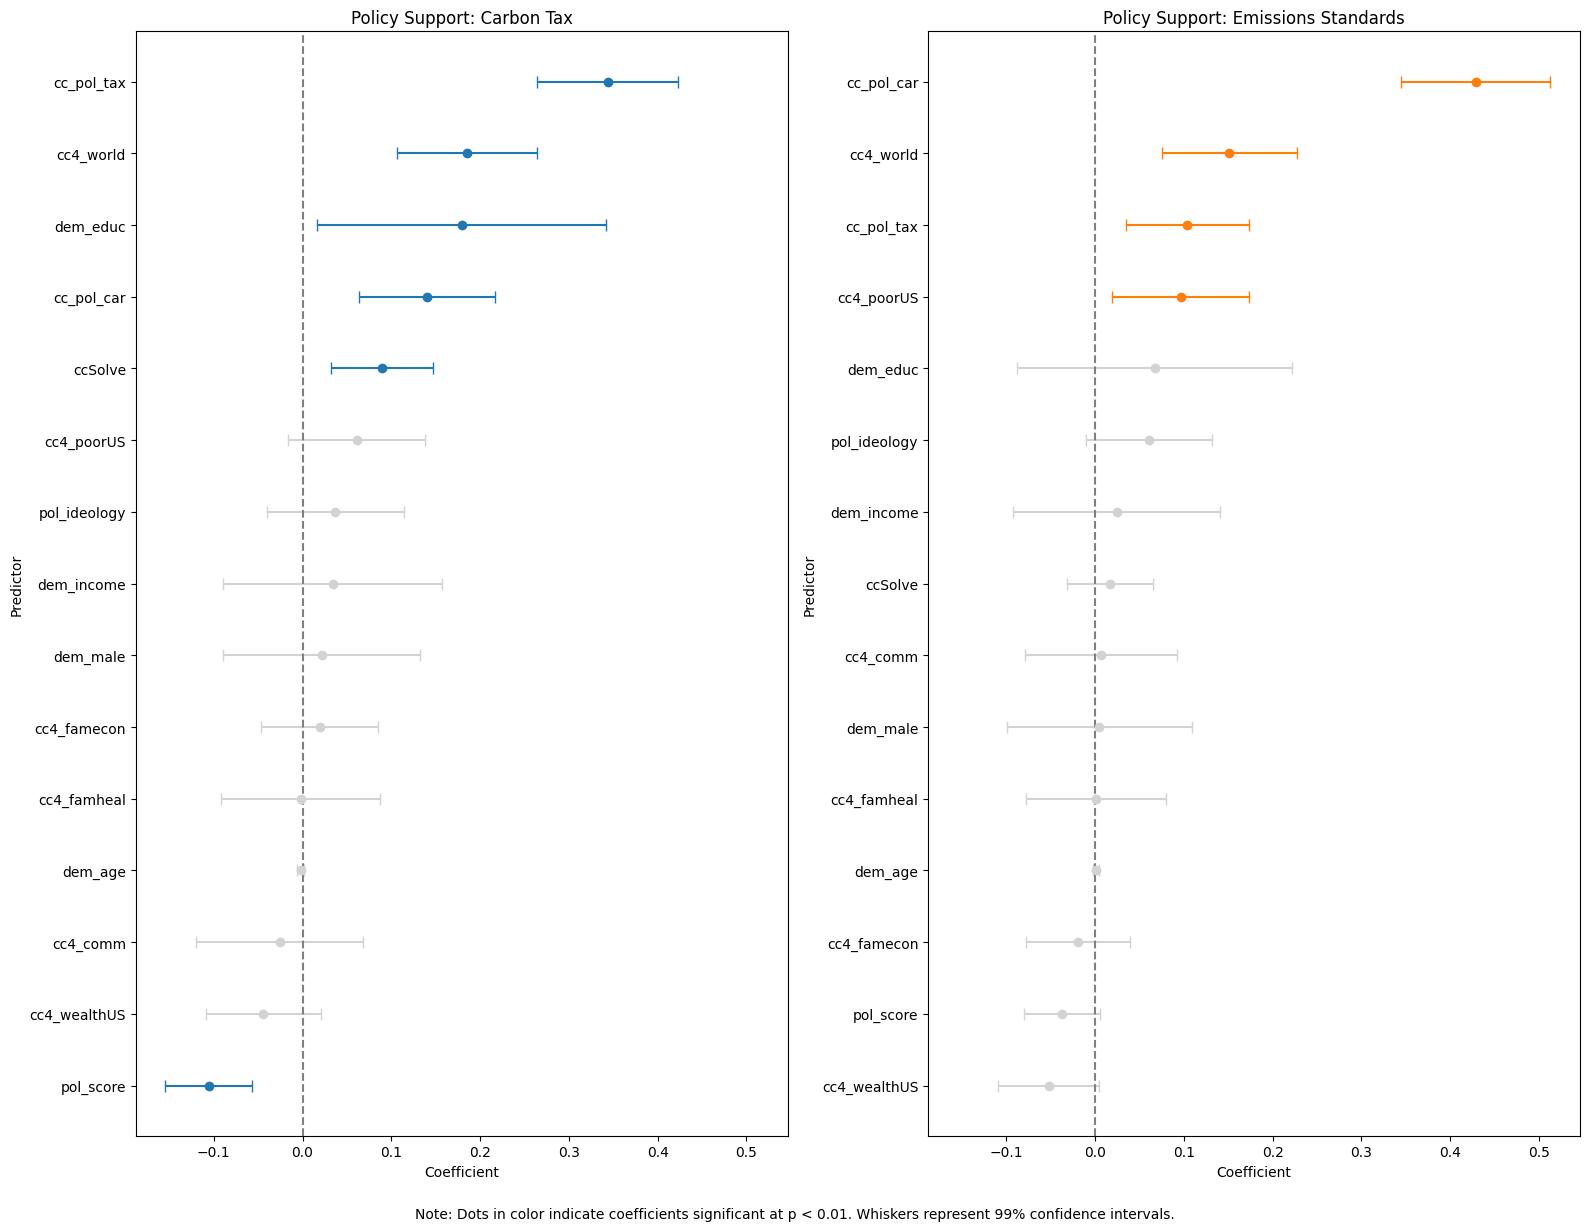

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import os
os.makedirs("../results", exist_ok=True)

# --- Helper function
def extract_model_info(model, label):
    coefs = model.params
    conf = model.conf_int(alpha=0.01)  # 99% CI
    pvals = model.pvalues  # Get p-values from model
    
    df = pd.DataFrame({
        'predictor': coefs.index,
        'coef': coefs.values,
        'lower': conf[0].values,
        'upper': conf[1].values,
        'pval': pvals.values,
        'model': label
    }).query("predictor != 'const'")
    
    # Previous threshold: p < 0.05 via 95% CI exclusion of zero
    # df['significant'] = ~((df['lower'] <= 0) & (df['upper'] >= 0))

    # New threshold: p < 0.01 via p-value
    df['significant'] = df['pval'] < 0.01

    df['predictor'] = df['predictor'].str.replace('_lag', '', regex=False)
    return df.sort_values(by='coef', ascending=True)

# --- Extract separately
df_tax = extract_model_info(model1, "cc_pol_tax_t")
df_car = extract_model_info(model2, "cc_pol_car_t")

# --- Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 12), sharex=True)

for ax, df, title, color in zip(
    axs,
    [df_tax, df_car],
    ["Policy Support: Carbon Tax", "Policy Support: Emissions Standards"],
    ["tab:blue", "tab:orange"]
):
    for _, row in df.iterrows():
        plot_color = color if row['significant'] else 'lightgray'
        ax.errorbar(
            row['coef'],
            row['predictor'],
            xerr=[[row['coef'] - row['lower']], [row['upper'] - row['coef']]],
            fmt='o',
            color=plot_color,
            ecolor=plot_color,
            capsize=4
        )
    ax.axvline(0, color='gray', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel("Coefficient")
    ax.set_ylabel("Predictor")

plt.tight_layout()
fig.text(
    0.5, -0.02,
    "Note: Dots in color indicate coefficients significant at p < 0.01. Whiskers represent 99% confidence intervals.",
    ha='center', fontsize=10
)
plt.savefig("../results/rq1_dot_whisker_policy_support.png", dpi=300)
plt.show()

> **Note:** Coefficients are sorted by their signed value (not absolute size) to reflect both magnitude (how strong) and direction of effect (positive or negative). Predictors whose 95% confidence intervals include zero (that are not statistically significant) are displayed in gray. This helps focus attention on the variables that clearly have an effect.
> 
> **Why not use absolute coefficients?**  
> Sorting by absolute coefficient size would show the predictors with the strongest effects first, regardless of whether those effects are positive or negative. However, in this analysis, we wanted to highlight **the direction** of each effect (e.g., does it increase or decrease support?). That’s why we sorted by the raw coefficient values - so variables that reduce support appear on one side of the plot, and those that increase it appear on the other.

> **Interpreting a Dot-Whisker Plot**
> A **dot-whisker plot** visualizes the results of regression models by showing each variable’s estimated effect and the uncertainty around it.
> * **Dots** represent **point estimates** (e.g., regression coefficients)
>   * Each dot shows the estimated impact of a predictor variable on the outcome.
> * **Whiskers (horizontal lines)** represent the **confidence intervals** around the estimates
>   * In this plot, we use **99% confidence intervals** (corresponding to **p < 0.01**).
>   * The wider the whisker, the greater the uncertainty in the estimate.
> * A **vertical line at zero** represents **no effect**
>   * If a whisker **crosses zero**, the effect is **not statistically significant** at the 99% level.
>   * If it **does not cross zero**, the effect is considered **statistically significant at p < 0.01**.
>
> This plot helps identify which predictors have **strong, highly significant effects**, and which are more uncertain or weaker. It reflects a stricter approach to significance, focusing only on the most robust relationships.

#### Panel VAR Analysis – RQ1 
*RQ1. Does support for climate policies (like carbon taxes or emissions standards) change during elections? And is this support influenced by personal or community-level perceptions of climate harm?*

The results show that people support carbon taxes and emissions standards more when they believe:
* Climate change harms the world (`cc4_world`)
* Poor people in the U.S. are disproportionately affected (`cc4_poorUS`)

Support is also strongly predicted by prior attitudes: individuals who previously supported either policy are significantly more likely to continue supporting it (`cc_pol_tax`, `cc_pol_car`). This suggests that policy support is **stable over time**, even during an election period.

However, **personal or community-level perceptions of harm** — such as concern about one’s own community or family health — do **not** significantly influence support at the stricter p < 0.01 level.

In the case of **carbon taxes specifically**, two additional factors stand out:
* **Higher education levels** are associated with greater support (`dem_educ`)
* **More conservative political orientation** is associated with lower support (`pol_score`)

These findings suggest that **global concern, fairness, and prior support** are the most robust drivers of climate policy support during elections.

---

### RQ2. Does willingness to pay for climate solutions vary during elections, and what factors influence it?
To investigate how willingness to financially support climate action evolves over time and whether it shifts during election periods, we estimate a **reduced-form Panel VAR(1)** model with `ccSolve_t` (willingness to pay for climate solutions) as the dependent variable.

The model includes the **lagged values** of 15 time-varying predictors capturing climate harm perceptions, policy attitudes, political identity, and demographic characteristics:
* **Harm perceptions** (lagged):
  `cc4_world`, `cc4_wealthUS`, `cc4_poorUS`, `cc4_comm`, `cc4_famheal`, `cc4_famecon`
* **Policy support** (lagged):
  `cc_pol_tax`, `cc_pol_car`
* **Willingness to pay (lagged)**:
  `ccSolve` (included as its own lag to model temporal dynamics)
* **Political identity** (lagged):
  `pol_score`, `pol_ideology` — treated as continuous variables
* **Demographics** (lagged):
  `dem_income`, `dem_age`, `dem_educ`, `dem_male`

The full equation is:

$$
\text{ccSolve}_t = \alpha 
+ \sum_{j=1}^{15} \beta_j \cdot X_{j,t-1} 
+ \epsilon_t
$$

Where:

* $X_{j,t-1}$ denotes the 15 lagged predictors
* $ \alpha $ is the intercept
* $ \epsilon_t $ is the individual-level error term, **clustered by respondent (`PID`)**

The model is estimated using **pooled OLS with cluster-robust standard errors**, based on 1,722 complete observations from three survey waves.

This specification allows us to assess not only which **attitudinal, political, or demographic factors** predict higher or lower willingness to pay for climate action, but also whether the **election period itself exerts a distinct effect**, controlling for prior beliefs and identities.

In [7]:
import statsmodels.api as sm
import pandas as pd

# Load data
data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)

# Define variables to be lagged
variables = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS",
    "cc4_comm", "cc4_famheal", "cc4_famecon",
    "ccSolve", "cc_pol_tax", "cc_pol_car",
    "dem_income", "dem_age", "dem_educ", "dem_male",
    "pol_score", "pol_ideology"
]

# Sort by PID and WAVE
data = data.sort_values(by=['PID', 'WAVE'])

# Create lagged versions of all predictors
for var in variables:
    data[f'{var}_lag'] = data.groupby('PID')[var].shift(1)

# Final predictors: lagged variables + wave dummy (not lagged)
lagged_vars = [f'{v}_lag' for v in variables]
all_predictors = lagged_vars

# Drop missing values
panel_var_data = data.dropna(subset=all_predictors + ['ccSolve'])

# Estimate the model: ccSolve_t
X = panel_var_data[all_predictors]
y = panel_var_data['ccSolve']
X = sm.add_constant(X)

rq2_model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': panel_var_data['PID']})

# Output results
print(rq2_model.summary())

                            OLS Regression Results                            
Dep. Variable:                ccSolve   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     8.969
Date:                Wed, 21 May 2025   Prob (F-statistic):           1.33e-19
Time:                        13:57:06   Log-Likelihood:                -2348.3
No. Observations:                1722   AIC:                             4729.
Df Residuals:                    1706   BIC:                             4816.
Df Model:                          15                                         
Covariance Type:              cluster                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.0155      0.154  

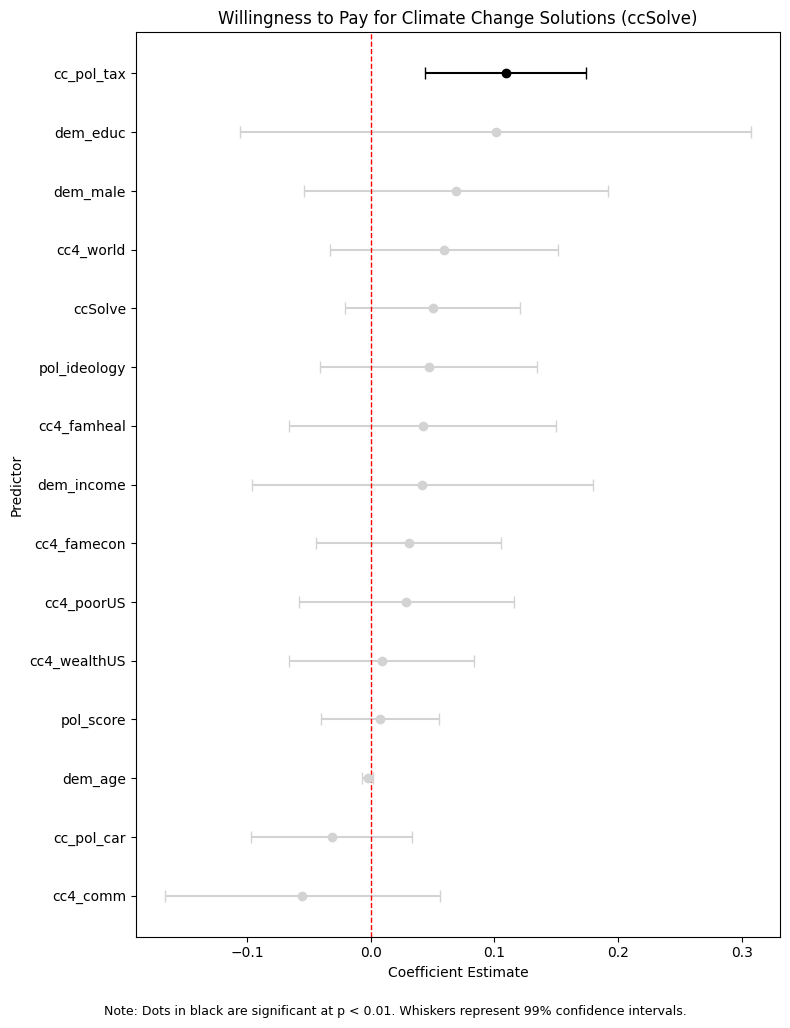

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import os
os.makedirs("../results", exist_ok=True)

# --- Step 1: Extract model coefficients and confidence intervals
def extract_model_info(model):
    coefs = model.params
    conf = model.conf_int(alpha=0.01)  # 99% CI
    pvals = model.pvalues  # Extract p-values

    df = pd.DataFrame({
        'predictor': coefs.index,
        'coef': coefs.values,
        'lower': conf[0].values,
        'upper': conf[1].values,
        'pval': pvals.values
    }).query("predictor != 'const'")  # exclude intercept

    # --- Previous threshold: p < 0.05 via 95% CI exclusion
    # df['significant'] = ~((df['lower'] <= 0) & (df['upper'] >= 0))

    # --- New threshold: p < 0.01
    df['significant'] = df['pval'] < 0.01
    return df

# --- Step 2: Extract info and sort predictors
plot_df = extract_model_info(rq2_model)
plot_df['predictor'] = plot_df['predictor'].str.replace('_lag', '', regex=False)
plot_df = plot_df.sort_values(by='coef', ascending=True)

# --- Step 3: Plot
plt.figure(figsize=(8, 10))

for _, row in plot_df.iterrows():
    plt.errorbar(
        row['coef'],
        row['predictor'],
        xerr=[[row['coef'] - row['lower']], [row['upper'] - row['coef']]],
        fmt='o',
        color='black' if row['significant'] else 'lightgray',
        ecolor='black' if row['significant'] else 'lightgray',
        capsize=4
    )

plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.title("Willingness to Pay for Climate Change Solutions (ccSolve)")
plt.xlabel("Coefficient Estimate")
plt.ylabel("Predictor")

# --- Add caption
plt.figtext(
    0.5, -0.02,
    "Note: Dots in black are significant at p < 0.01. Whiskers represent 99% confidence intervals.",
    ha='center', fontsize=9
)

plt.tight_layout()
plt.savefig("../results/rq2_dot_whisker_ccSolve_coefficients.png", dpi=300)
plt.show()

#### Panel VAR Analysis – RQ2
*RQ2. Does willingness to pay for climate solutions vary during elections, and what factors influence it?*

> **Willingness to pay for climate solutions does not appear to change significantly during elections.**
> 
> Among all the predictors, **only one variable** — **prior support for a carbon tax (`cc_pol_tax`)** — is a **strong and statistically significant predictor** of willingness to pay for climate solutions (`ccSolve`). This suggests that people who already support climate measures are more likely to express financial willingness to contribute to solutions.
> 
> **No other factors**, including perceptions of climate harm to the world, the poor, the wealthy, or one’s community, show statistically significant associations at the stricter p < 0.01 level. Demographics (e.g., age, gender, education, income) and political orientation also do **not** show strong effects in this model.
> 
> **Therefore, the answer to RQ2 is that willingness to pay is stable across the election period** and is **primarily influenced by existing policy support (carbon tax)**.

---

### RQ3. Does political ideology moderate the relationship between perceptions of harm and willingness to pay for climate solutions?
To explore this question, we extend the **Panel VAR(1)** framework by estimating a model with `ccSolve_t` (willingness to financially support climate action) as the dependent variable. Our objective is to assess whether the impact of perceived climate harm on willingness to pay **varies by political ideology**.

We include **interaction terms between lagged harm perception variables and respondents’ ideological self-placement** (`pol_ideology`), allowing us to test whether the strength or direction of these relationships depends on political views. The model also controls for prior willingness to pay, support for climate policies, demographic characteristics

* **Harm perceptions** (lagged):
  `cc4_world`, `cc4_wealthUS`, `cc4_poorUS`, `cc4_comm`, `cc4_famheal`, `cc4_famecon`
* **Political ideology**:
  `pol_ideology` (treated as a continuous or ordinal variable)
* **Interaction terms**:
  Each lagged harm variable is interacted with `pol_ideology`, e.g.,
  `cc4_world_lag × pol_ideology`, ..., `cc4_famecon_lag × pol_ideology`
* **Other controls** (lagged):
  * **Willingness to pay**: `ccSolve`
  * **Policy support**: `cc_pol_tax`, `cc_pol_car`
  * **Demographics**: `dem_income`, `dem_educ`, `dem_age`, `dem_male`

The regression equation is estimated as:
$$
\text{ccSolve}_t = \alpha 
+ \sum_{j=1}^{6} \beta_j \cdot H_{j,t-1} 
+ \gamma \cdot \text{Ideology}_{t-1} 
+ \sum_{j=1}^{6} \delta_j \cdot (H_{j,t-1} \cdot \text{Ideology}_{t-1}) 
+ \sum_{k} \lambda_k \cdot Z_{k,t-1} 
+ \epsilon_t
$$

Where:
* $H_{j,t-1}$ are the lagged harm perception variables
* $\text{Ideology}_{t-1}$ is the lagged political ideology score
* $H_{j,t-1} \cdot I_k$ are the interaction terms between perceptions and ideology
* $Z_{l,t-1}$ are other controls (policy support, demographics)
* $\epsilon_t$ is the error term, clustered at the respondent level

The model is estimated using **pooled OLS with cluster-robust standard errors**, based on complete responses across Waves 2–4.

By explicitly interacting political ideology with climate harm perceptions, this specification allows us to test whether **individuals with different ideological leanings respond differently to perceived climate risks** when forming their willingness to pay for solutions. This helps uncover conditional effects that would be masked in non-interactive models.

In [2]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import pandas as pd

# Load data
data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)

# Define variable groups
harm_vars = ["cc4_world", "cc4_wealthUS", "cc4_poorUS", "cc4_comm", "cc4_famheal", "cc4_famecon"]
moderator = "pol_ideology"  # or use "pol_score" if you prefer
controls = ["ccSolve", "cc_pol_tax", "cc_pol_car", "dem_income", "dem_age", "dem_educ", "dem_male"]

# Sort by PID and WAVE
data = data.sort_values(by=["PID", "WAVE"])

# Create lagged versions
for var in harm_vars + controls + [moderator]:
    data[f"{var}_lag"] = data.groupby("PID")[var].shift(1)

# Create interaction terms between lagged harm perception and moderator
for harm in harm_vars:
    data[f"{harm}_x_{moderator}_lag"] = data.groupby("PID")[harm].shift(1) * data[moderator]

# Combine all predictors
lagged_vars = [f"{var}_lag" for var in harm_vars + controls + [moderator]]
interaction_terms = [f"{harm}_x_{moderator}_lag" for harm in harm_vars]
all_predictors = lagged_vars + interaction_terms

# Drop missing rows
panel_var_data = data.dropna(subset=all_predictors + ["ccSolve"])

# Define outcome and predictors
X = panel_var_data[all_predictors]
y = panel_var_data["ccSolve"]
X = sm.add_constant(X)

# Fit model
rq3_model = sm.OLS(y, X).fit(cov_type="cluster", cov_kwds={"groups": panel_var_data["PID"]})

# Print summary
print(summary_col([rq3_model], stars=True, model_names=["ccSolve_t"],
                  info_dict={"N": lambda x: f"{int(x.nobs)}"}))


                                ccSolve_t
-----------------------------------------
const                           1.1803***
                                (0.1570) 
cc4_world_lag                   0.0811   
                                (0.1062) 
cc4_wealthUS_lag                0.0259   
                                (0.0862) 
cc4_poorUS_lag                  -0.0627  
                                (0.1025) 
cc4_comm_lag                    -0.0365  
                                (0.1405) 
cc4_famheal_lag                 0.0238   
                                (0.1440) 
cc4_famecon_lag                 0.0341   
                                (0.0953) 
ccSolve_lag                     0.0516*  
                                (0.0275) 
cc_pol_tax_lag                  0.1071***
                                (0.0254) 
cc_pol_car_lag                  -0.0296  
                                (0.0253) 
dem_income_lag                  0.0463   
                                (

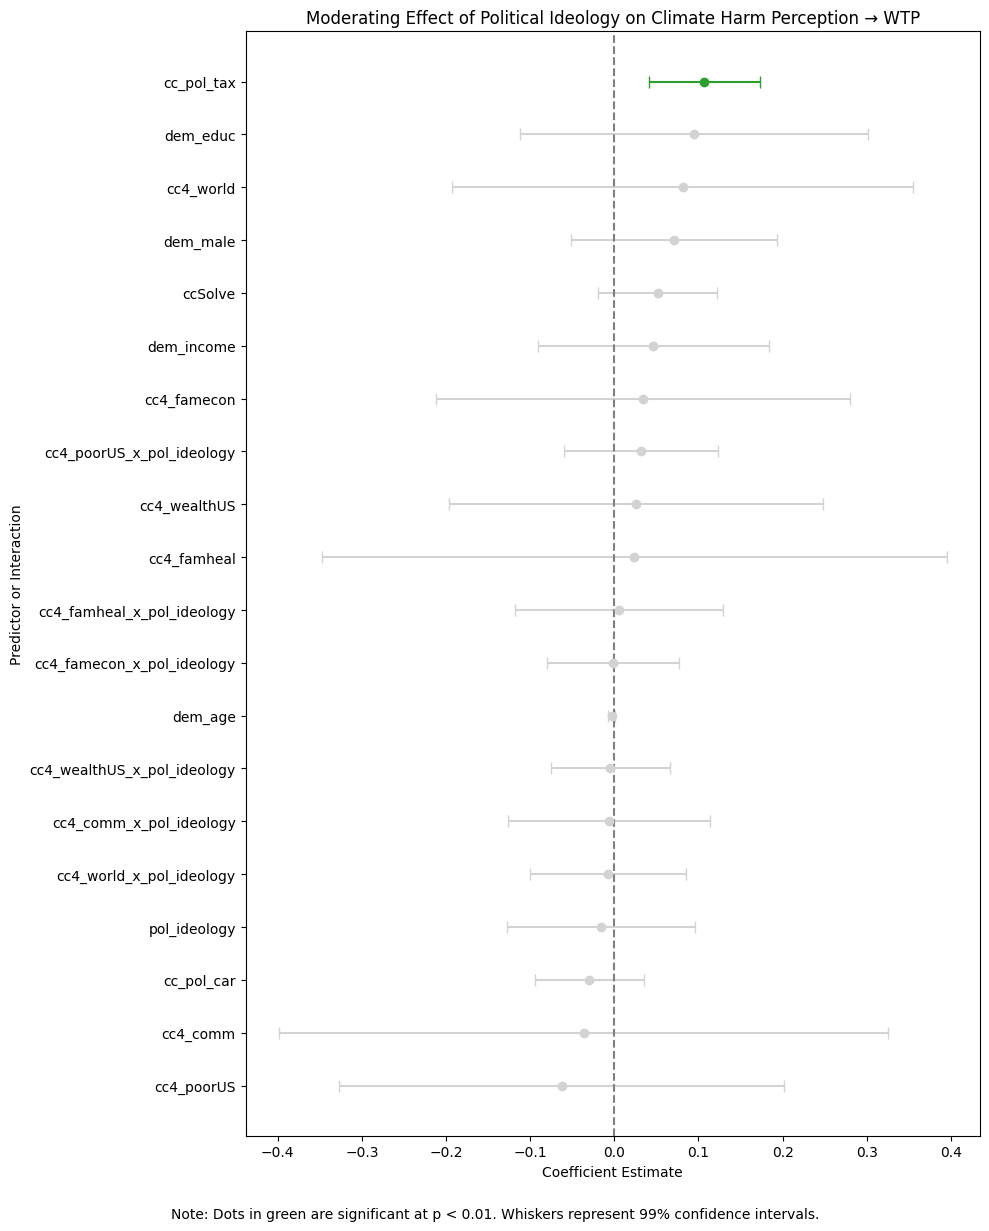

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import os
os.makedirs("../results", exist_ok=True)

# --- Helper function for RQ3 model
def extract_rq3_model_info(model):
    coefs = model.params

    # --- Updated: use 99% confidence intervals
    conf = model.conf_int(alpha=0.01)

    # --- Updated: extract p-values for p < 0.01 threshold
    pvals = model.pvalues

    df = pd.DataFrame({
        'predictor': coefs.index,
        'coef': coefs.values,
        'lower': conf[0].values,
        'upper': conf[1].values,
        'pval': pvals.values
    }).query("predictor != 'const'")

    # --- Updated: significance based on p < 0.01
    df['significant'] = df['pval'] < 0.01

    # --- Original logic (for reference)
    # conf = model.conf_int()  # 95% CI by default
    # df['significant'] = ~((conf[0] <= 0) & (conf[1] >= 0))

    # Clean up names
    df['predictor'] = df['predictor'].str.replace('_lag', '', regex=False)
    df['predictor'] = df['predictor'].str.replace(':', ' × ')  # interaction formatting
    return df.sort_values(by='coef', ascending=True)

# --- Extract model info
plot_df = extract_rq3_model_info(rq3_model)

# --- Plotting
plt.figure(figsize=(10, 12))
for _, row in plot_df.iterrows():
    color = 'tab:green' if row['significant'] else 'lightgray'
    plt.errorbar(
        row['coef'],
        row['predictor'],
        xerr=[[row['coef'] - row['lower']], [row['upper'] - row['coef']]],
        fmt='o',
        color=color,
        ecolor=color,
        capsize=4
    )

plt.axvline(0, color='gray', linestyle='--')
plt.title("Moderating Effect of Political Ideology on Climate Harm Perception → WTP")
plt.xlabel("Coefficient Estimate")
plt.ylabel("Predictor or Interaction")

# --- Updated: note for 99% CI and p < 0.01 threshold
plt.figtext(
    0.5, -0.02,
    "Note: Dots in green are significant at p < 0.01. Whiskers represent 99% confidence intervals.",
    ha='center', fontsize=10
)

plt.tight_layout()
plt.savefig("../results/rq3_dot_whisker_moderation.png", dpi=300)
plt.show()

#### Interaction Model – RQ3
*RQ3. Does political ideology moderate the relationship between perceptions of harm and willingness to pay for climate solutions?*

**Short answer: No, not meaningfully — at least not at a high threshold of significance.**

Among all the predictors and interaction terms in this model, the **only statistically significant predictor** (p < 0.01) is:
* **Prior support for a carbon tax (`cc_pol_tax`)**: People who previously supported carbon taxation are much more likely to express a willingness to pay for climate solutions.

None of the interaction terms — including, for example:
* `cc4_world × pol_ideology`
* `cc4_poorUS × pol_ideology`
* `cc4_comm × pol_ideology`

— were statistically significant at the **99% confidence level**. This means that **political ideology does not appear to significantly alter the effect of climate harm perceptions on willingness to pay**, at least in this dataset.

> **Long answer:** Willingness to pay for climate solutions appears to be **primarily driven by existing policy attitudes** (such as support for a carbon tax), and **not significantly shaped by ideology moderating the perception of harm**. People's views on who is harmed by climate change (e.g., the world, poor communities) do not interact with their political ideology in a way that meaningfully affects their willingness to contribute financially.

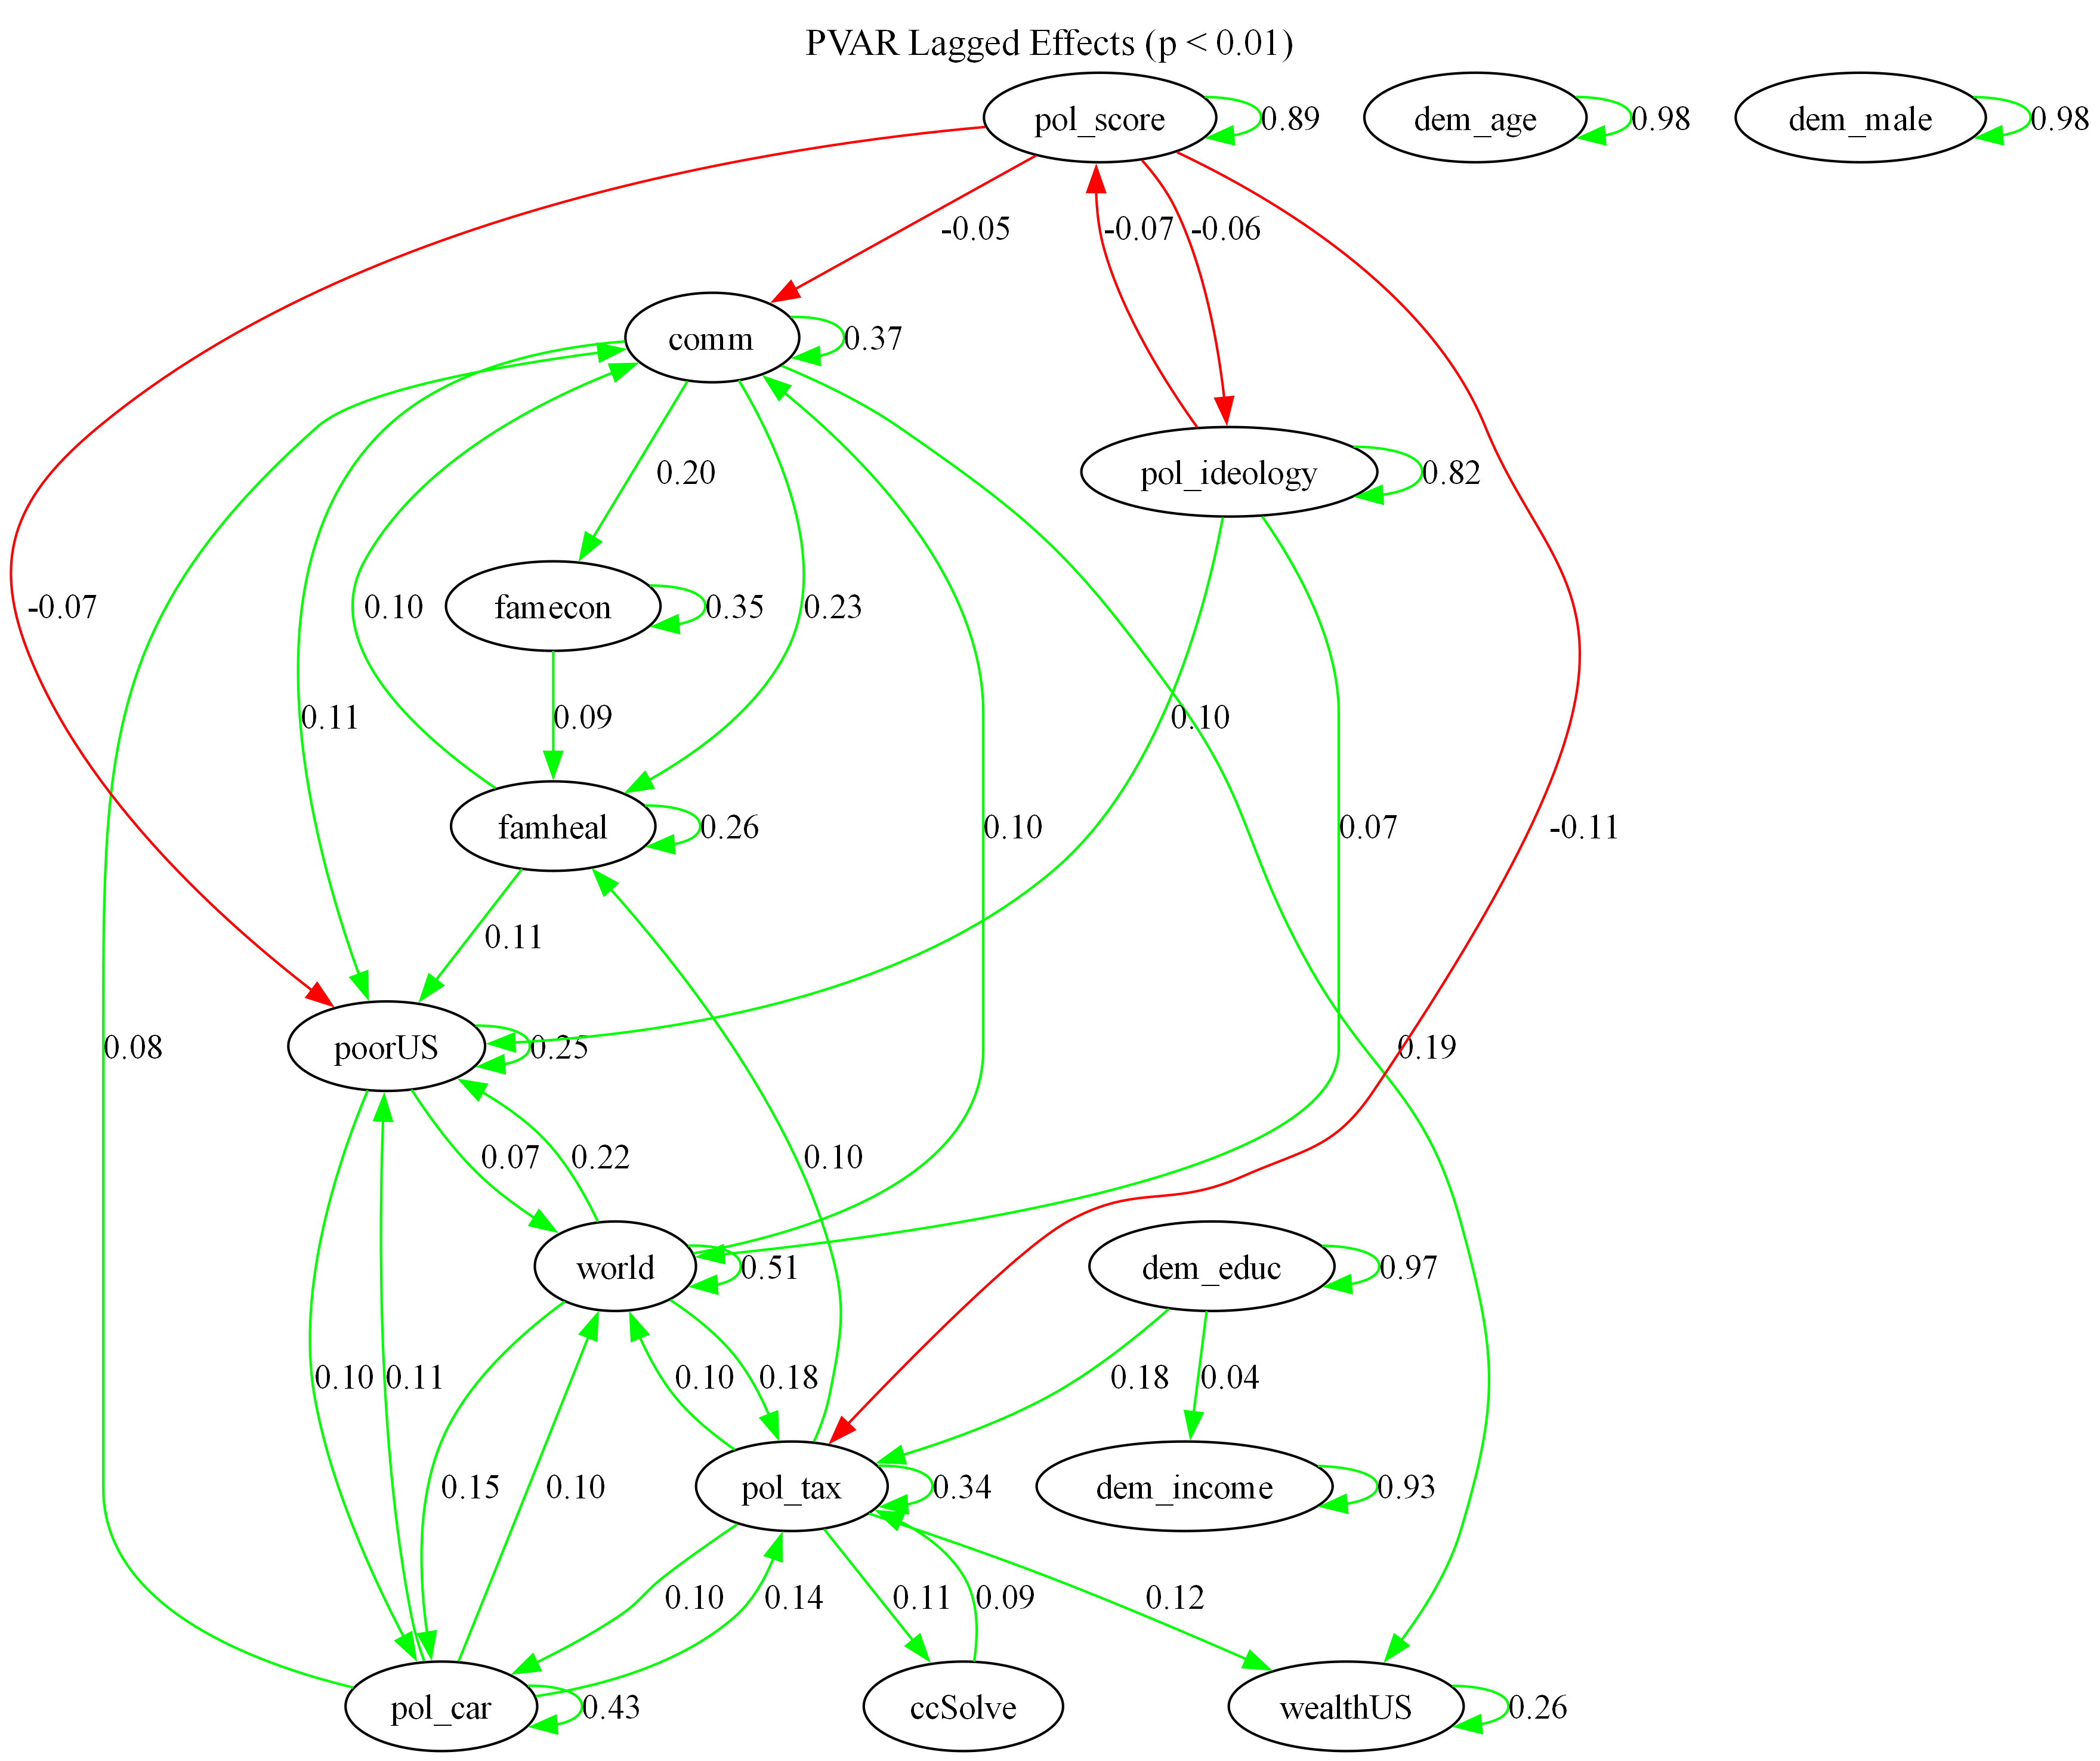

In [13]:
import os
import pandas as pd
import statsmodels.api as sm
import networkx as nx
from graphviz import Digraph
from IPython.display import Image, display

# Optional: Add path to Graphviz binaries if needed
# os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

# --- Load data ---
data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)

# --- Define predictors ---
continuous_predictors = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS",
    "cc4_comm", "cc4_famheal", "cc4_famecon",
    "ccSolve", "cc_pol_tax", "cc_pol_car",
    "dem_income", "dem_age", "dem_educ", "dem_male",
    "pol_score", "pol_ideology"
]

# --- Preprocess ---
data = data.sort_values(by=['PID', 'WAVE'])
for var in continuous_predictors:
    data[f"{var}_lag"] = data.groupby("PID")[var].shift(1)

X_vars = [f"{var}_lag" for var in continuous_predictors]
Y_vars = continuous_predictors
df = data.dropna(subset=X_vars + Y_vars)

# --- Build edge list based on lagged regression ---
edges = []
for y in Y_vars:
    X = df[X_vars]
    X = sm.add_constant(X)
    y_vals = df[y]
    model = sm.OLS(y_vals, X).fit()

    for predictor, pval in model.pvalues.items():
        if predictor == 'const' or predictor not in X.columns:
            continue
        
        # --- Previous threshold: p < 0.05
        # if pval < 0.05:

        # --- New threshold: p < 0.01
        if pval < 0.01:
            weight = model.params[predictor]
            source = predictor.replace("_lag", "")
            target = y
            edges.append((source, target, weight))

# --- Build Graphviz Digraph ---
dot = Digraph(engine="dot")
dot.attr(dpi='300', fontsize='14', rankdir='TB')
dot.attr(label='PVAR Lagged Effects (p < 0.01)', labelloc='t', fontsize='15')

# --- Add nodes
nodes = set()
for src, tgt, _ in edges:
    nodes.update([src, tgt])

for node in sorted(nodes):
    label = node.replace("cc4_", "").replace("cc_", "")
    dot.node(node, label=label)

# --- Add edges
for src, tgt, weight in edges:
    color = "green" if weight > 0 else "red"
    dot.edge(src, tgt, label=f"{weight:.2f}", color=color)

# --- Render and save PNG only (no viewer, no .gv file)
output_path = "../results/pvar_graphviz"
dot.render(output_path, format="png", cleanup=True)

# --- Display the PNG below the cell
display(Image(filename=f"{output_path}.png"))

In [15]:
import pandas as pd
import numpy as np

# --- Load data ---
df = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)
print("Variable types:\n", df[variables].dtypes)
print("\n Sample values:\n", df[variables].head())

# --- Define your analysis variables ---
variables = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS",
    "cc4_comm", "cc4_famheal", "cc4_famecon",
    "ccSolve", "cc_pol_tax", "cc_pol_car",
    "dem_income", "dem_age", "dem_educ", "dem_male",
    "pol_score", "pol_ideology"
]

# --- Sort by PID and WAVE ---
df = df.sort_values(['PID', 'WAVE'])

# --- Ensure all PIDs have the same number of timepoints ---
obs_per_pid = df.groupby('PID').size()
print("Unique observation counts per PID:\n", obs_per_pid.value_counts())

# Filter only PIDs with exactly 3 timepoints
valid_pids = obs_per_pid[obs_per_pid == 3].index
df = df[df['PID'].isin(valid_pids)]
print(f"Using {len(valid_pids)} PIDs with 3 timepoints each.")

# --- Construct panel array (T, N, C) ---
panel_data = []
units = df['PID'].unique()

for pid in units:
    sub_df = df[df['PID'] == pid].sort_values('WAVE')
    if sub_df.shape[0] < 3:
        continue
    panel_data.append(sub_df[variables].values)

# Convert to panel array: T x N x C
panel_array = np.stack(panel_data, axis=-1)
print("Shape of panel_array (T, N, C):", panel_array.shape)

# --- Check for NaNs and Infs ---
print("NaNs in panel_array:", np.isnan(panel_array).sum())
print("Infs in panel_array:", np.isinf(panel_array).sum())

T, N, C = panel_array.shape
reshaped = panel_array.transpose(1, 0, 2).reshape(N, T * C)  # shape: (N, T*C)
flat_stds = np.std(reshaped, axis=1)

# Drop variables with zero overall variance
non_constant_indices = [i for i, std in enumerate(flat_stds) if std > 0]
panel_array = panel_array[:, non_constant_indices, :]
variables = [variables[i] for i in non_constant_indices]

print("Dropped variables with no variance across the full panel.")
print("New panel_array shape:", panel_array.shape)
print("Variables retained:", variables)

Variable types:
 cc4_world       float64
cc4_wealthUS    float64
cc4_poorUS      float64
cc4_comm        float64
cc4_famheal     float64
cc4_famecon     float64
ccSolve           int64
cc_pol_tax      float64
cc_pol_car      float64
dem_income        int64
dem_age           int64
dem_educ          int64
dem_male          int64
pol_score         int64
pol_ideology      int64
dtype: object

 Sample values:
    cc4_world  cc4_wealthUS  cc4_poorUS  cc4_comm  cc4_famheal  cc4_famecon  \
0       3.67          1.00        3.67      3.67         3.67         2.33   
1       5.00          3.67        5.00      3.67         3.67         2.33   
2       3.67          2.33        2.33      2.33         2.33         2.33   
3       3.67          3.67        5.00      2.33         2.33         2.33   
4       5.00          3.67        5.00      2.33         2.33         1.00   

   ccSolve  cc_pol_tax  cc_pol_car  dem_income  dem_age  dem_educ  dem_male  \
0        2         4.0         4.0         

In [16]:
import numpy as np
from tigramite.data_processing import DataFrame
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr

# Assuming panel_array has shape (T, N, C)
T, N, C = panel_array.shape

# Reshape panel_array to (T*C, N)
reshaped_data = panel_array.transpose(2, 0, 1).reshape(T * C, N)

# Create Tigramite DataFrame
dataframe = DataFrame(data=reshaped_data, var_names=variables)

# Set up PCMCI with partial correlation test
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=ParCorr(significance='analytic'))

# Run PCMCI with tau_max = 1 (1 lag)
results = pcmci.run_pcmci(tau_max=1, pc_alpha=0.05)

# Print significant links at alpha = 0.05
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                              val_matrix=results['val_matrix'],
                              alpha_level=0.05)



## Significant links at alpha = 0.05:

    Variable cc4_world has 16 link(s):
        (cc4_poorUS  0): pval = 0.00000 | val =  0.756
        (cc4_comm  0): pval = 0.00000 | val =  0.674
        (cc4_famheal  0): pval = 0.00000 | val =  0.580
        (cc4_wealthUS  0): pval = 0.00000 | val =  0.580
        (cc_pol_car  0): pval = 0.00000 | val =  0.486
        (cc_pol_tax  0): pval = 0.00000 | val =  0.476
        (cc4_famecon  0): pval = 0.00000 | val =  0.398
        (pol_score  0): pval = 0.00000 | val = -0.365
        (pol_ideology  0): pval = 0.00000 | val =  0.360
        (cc4_world -1): pval = 0.00000 | val =  0.235
        (ccSolve  0): pval = 0.00000 | val =  0.148
        (pol_score -1): pval = 0.00000 | val = -0.092
        (cc_pol_tax -1): pval = 0.00001 | val =  0.086
        (cc4_comm -1): pval = 0.00005 | val =  0.080
        (dem_age  0): pval = 0.00291 | val = -0.059
        (pol_ideology -1): pval = 0.02147 | val =  0.045

    Variable cc4_wealthUS has 17 link(s):
   

In [17]:
# Configuration
tau_max = 1  # maximum time lag to test
pc_alpha = 0.01  # significance level for PC-stable algorithm
pcmci.verbosity = 2 # verbosity: 0 (silent), 1 (basic), 2 (detailed)

# Run PCMCI+
results = pcmci.run_pcmciplus(tau_min=0, tau_max=tau_max, pc_alpha=pc_alpha)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 1
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Variable cc4_world

Iterating through pc_alpha = [0.01]:

# pc_alpha = 0.01 (1/1):

Testing condition sets of dimension 0:

    Link (cc4_world -1) -?> cc4_world (1/15):
    Subset 0: () gives pval = 0.00000 / val =  0.511
    No conditions of dimension 0 left.

    Link (cc4_wealthUS -1) -?> cc4_world (2/15):
    Subset 0: () gives pval = 0.00000 / val =  0.343
    No conditions of dimension 0 left.

    Link (cc4_poorUS -1) -?> cc4_world (3/15):
    Subset 0: () gives pval = 0.00000 / val =  0.455
    No conditions of dimension 0 left.

    Link (cc4_comm -1) -?> cc4_world (4/15):
    Subset 0: () gives pval = 0.00000 / val =  0.428
    No conditions of dimension 0 left.

    Link (cc4_famheal -1) -?> cc4_world (5/15):
    Subset 0: () gives pval = 0.00000 / val =  0.376
    No conditions of

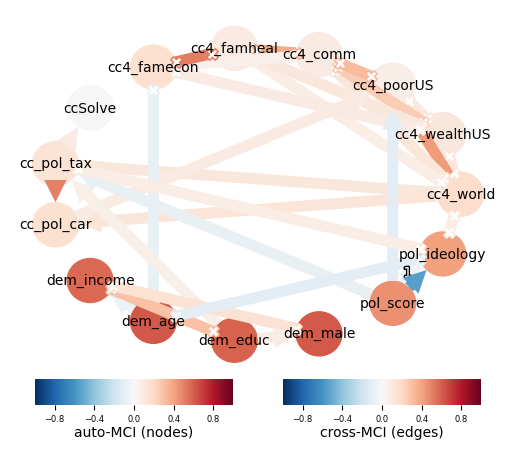

In [18]:
from tigramite import plotting as tp
import matplotlib.pyplot as plt

# Unpack the figure and axes
fig, ax = tp.plot_graph(
    graph=results['graph'],
    val_matrix=results['val_matrix'],
    var_names=variables,
    link_colorbar_label='cross-MCI (edges)',
    node_colorbar_label='auto-MCI (nodes)'
)

# Save the figure
fig.savefig("../results/pcmci_graph.png", dpi=300, bbox_inches='tight')